In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
from prophet import Prophet

# Hide Stanpy logs
import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# UAH satellite temperature dataset

In [2]:
def get_UAH_data():
    url = "https://www.nsstc.uah.edu/data/msu/v6.0/tlt/uahncdc_lt_6.0.txt"
    response = requests.get(url)
    lines = [i.decode().split() for i in response.iter_lines()]
    columns = lines[0]
    records = []
    for line in lines[1:]:
        try:
            year = int(line[0])
            record = dict(zip(columns, line))
            records.append(record)
        except:
            break
    df = pd.DataFrame(records)
    df.index = pd.to_datetime(df['Year'] + "-" + df['Mo'] + "-" + '01')
    df = df.drop(['Year', 'Mo'],axis=1)
    df = df.astype(float)
    df = df.sort_index()
    df = df[['Globe']]
    df = df.rename(columns={'Globe': 'satellite_global'}) 
    return df

In [3]:
satellite_temp = get_UAH_data()

In [4]:
satellite_temp.tail()

,satellite_global
2022-11-01,0.17
2022-12-01,0.05
2023-01-01,-0.04
2023-02-01,0.08
2023-03-01,0.20


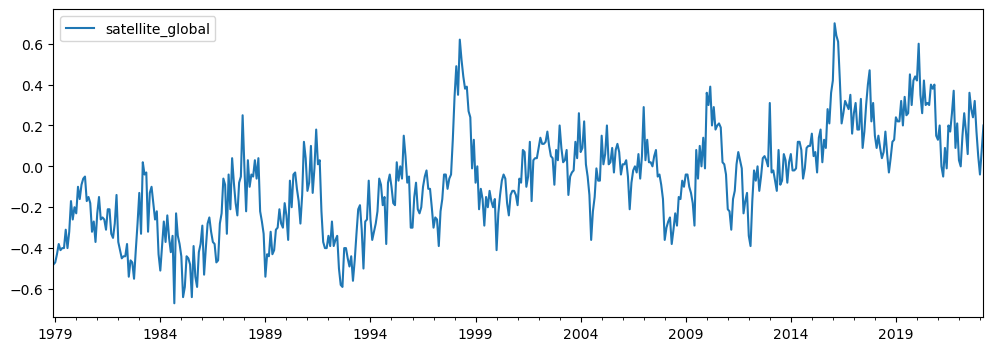

In [5]:
satellite_temp.plot(figsize=(12,4));

# GISS Surface Temperature Analysis (GISTEMP v4)

In [6]:
def get_gistemp_data():
    url = "https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv"
    df = pd.read_csv(url,skiprows=1)
    df.index = df['Year']
    del df['Year']
    df = df.melt(ignore_index=False)
    df.columns = ['Month', 'Globe']
    df = df.reset_index()
    df = df[df['Month'].isin(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep',
       'Oct', 'Nov', 'Dec'])]
    df.index = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str) + '-01')
    df = df.drop(['Year', 'Month'],axis=1)
    df = df.sort_index()
    df['Globe'] = df['Globe'].replace('***',None)
    df = df.dropna()
    df = df.astype(float)
    df = df.rename(columns={'Globe': 'surface_global'}) 
    return df

In [7]:
surface_temp = get_gistemp_data()

In [8]:
surface_temp.tail()

,surface_global
2022-10-01,0.97
2022-11-01,0.73
2022-12-01,0.79
2023-01-01,0.86
2023-02-01,0.97


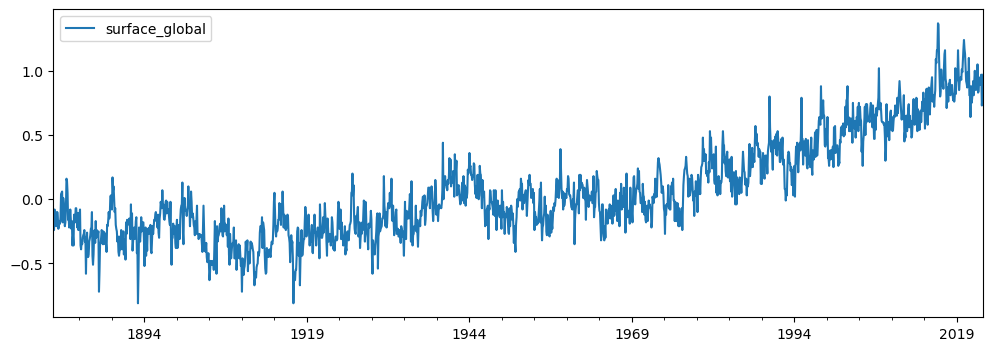

In [9]:
surface_temp.plot(figsize=(12,4));

# Comparison

In [10]:
df = pd.merge(satellite_temp, surface_temp, how='left', left_index=True, right_index=True).dropna()

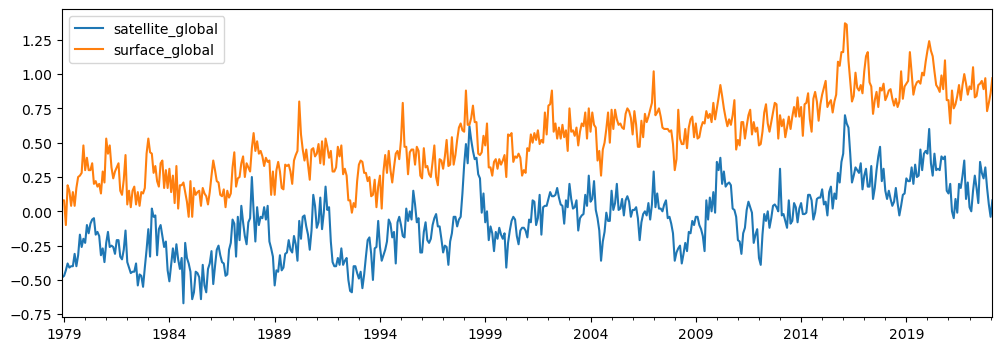

In [11]:
df.plot(figsize=(12,4));

# Seasonal Decomposition

In [12]:
def seasonality_plot_df(m, ds):
    df_dict = {'ds': ds, 'cap': 1., 'floor': 0.}
    for name in m.extra_regressors:
        df_dict[name] = 0.
    for props in m.seasonalities.values():
        if props['condition_name'] is not None:
            df_dict[props['condition_name']] = True
    df = pd.DataFrame(df_dict)
    df = m.setup_dataframe(df)
    return df

In [13]:
def plot_seasonal_component(model, ax):
    days = (pd.date_range(start='2017-01-01', periods=365))
    df_y = seasonality_plot_df(model, days)
    seas = model.predict_seasonal_components(df_y)
    seas.index = df_y['ds']
    month_seas = seas[['yearly_lower', 'yearly_upper']].resample('m').mean()
    month_seas['error'] = month_seas['yearly_upper'] - month_seas['yearly_lower']
    month_seas['yearly_midpoint'] = (month_seas['yearly_lower'] + month_seas['yearly_upper'])/2
    month_seas.index = pd.Series(month_seas.index).apply(lambda x: x.strftime('%B'))
    month_seas[['yearly_midpoint']].plot(kind='barh', legend=False, title='Seasonal Component', xerr=month_seas['error'], align='center', alpha=0.5, ecolor='black', capsize=2, ax=ax)
    ax.set(ylabel=None)
    plt.gca().invert_yaxis()
    return ax

In [14]:
def fit_model(df, col):
    df = df.copy()
    df['ds'] = df.index
    df['y'] = df[col]
    model = Prophet(interval_width=0.95, mcmc_samples=300, yearly_seasonality=False, weekly_seasonality=False)
    model.add_seasonality(name='yearly', period=365.25, fourier_order=5)
    model.fit(df, show_progress=False)
    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)
    forecast.index = forecast['ds'].dt.to_pydatetime()
    return model, forecast

In [15]:
def plot_trend_and_seasonal_components(model, forecast, title):
    fig = plt.figure(figsize=(14, 8), constrained_layout=False, dpi=120)
    gs = fig.add_gridspec(20, 20)
    fig.suptitle(title, fontsize=16)
    ax1 = fig.add_subplot(gs[0:10, 0:13])
    forecast['trend'].plot(title='Trend Component', ax=ax1)
    ax1.fill_between(forecast.index, forecast['trend_lower'], forecast['trend_upper'],
            color='#0072B2', alpha=0.2)
    ax2 = fig.add_subplot(gs[0:10, 15:20])
    plot_seasonal_component(model, ax2)
    fig.subplots_adjust(top=0.90);

## Satellite Global Temperatures

In [16]:
satellite_model, satellite_forecast = fit_model(df, col='satellite_global')

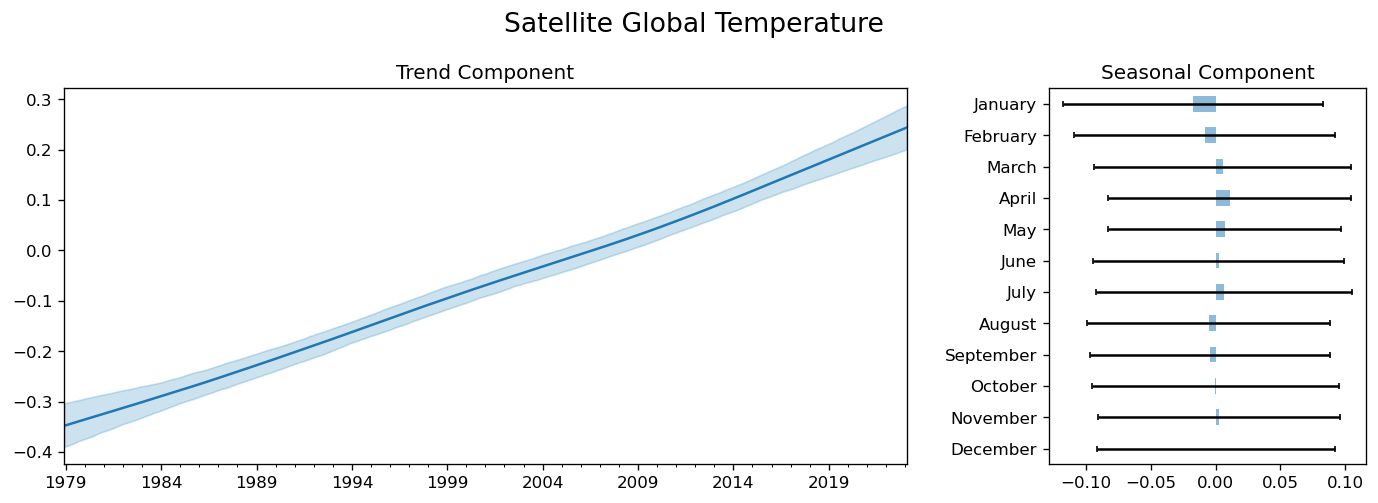

In [17]:
plot_trend_and_seasonal_components(satellite_model, satellite_forecast, title='Satellite Global Temperature')

## Surface Global Temperatures

In [18]:
surface_model, surface_forecast = fit_model(df, col='surface_global')

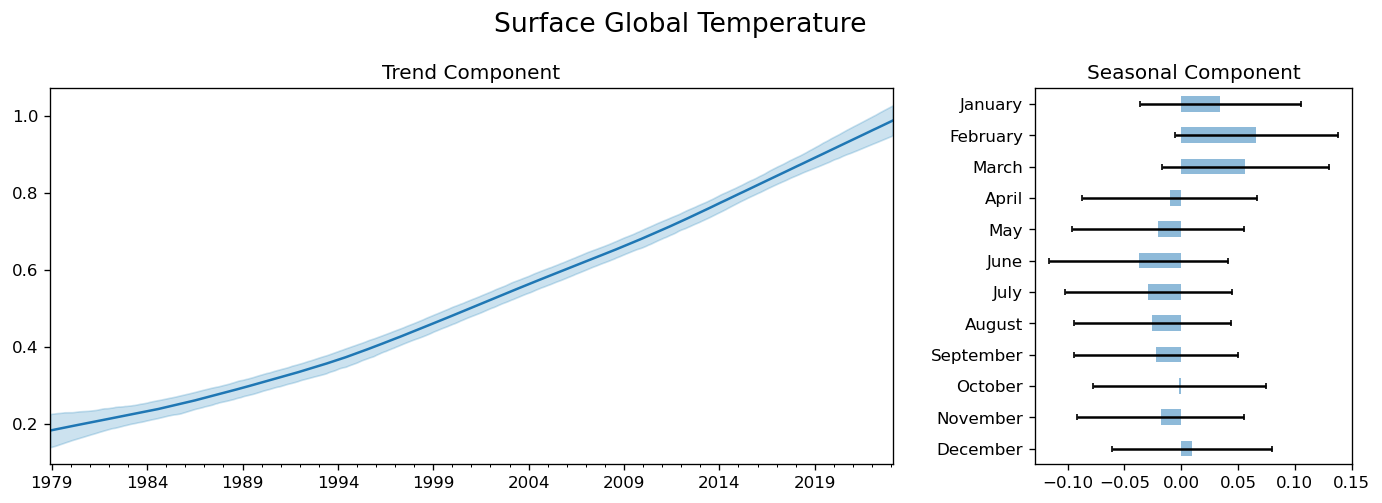

In [19]:
plot_trend_and_seasonal_components(surface_model, surface_forecast, title='Surface Global Temperature')

## Trend Comparison

The satellite data contains temperature anomalies compared to 1991-2020 means.

The surface data contains temperature anomalies compared to 1951-1980 means.

The below step adjusts the satellite data upwards so that start from the same place in December 1979. 

This adjustment does not impact the slope of either trend lines, only the starting point for the satellite record for ease of comparison.

In [20]:
start_date = '1979-12-01'

In [21]:
satellite_trend = satellite_forecast.loc[start_date:]['trend']
satellite_trend_upper = satellite_forecast.loc[start_date:]['trend_upper']
satellite_trend_lower = satellite_forecast.loc[start_date:]['trend_lower']

In [22]:
surface_trend = surface_forecast.loc[start_date:]['trend']
surface_trend_upper = surface_forecast.loc[start_date:]['trend_upper']
surface_trend_lower = surface_forecast.loc[start_date:]['trend_lower']

In [23]:
satellite_trend.iloc[[0]]

1979-12-01   -0.336628
Name: trend, dtype: float64

In [24]:
surface_trend.iloc[[0]]

1979-12-01    0.191796
Name: trend, dtype: float64

In [25]:
baseline_delta = surface_trend.iloc[0] - satellite_trend.iloc[0]

In [26]:
print("Adjusting the satellite trendline by:", baseline_delta, "degrees Celsius.")
satellite_trend_adj = satellite_trend + baseline_delta
satellite_trend_upper_adj = satellite_trend_upper + baseline_delta
satellite_trend_lower_adj = satellite_trend_lower + baseline_delta

Adjusting the satellite trendline by: 0.5284239948866403 degrees Celsius.


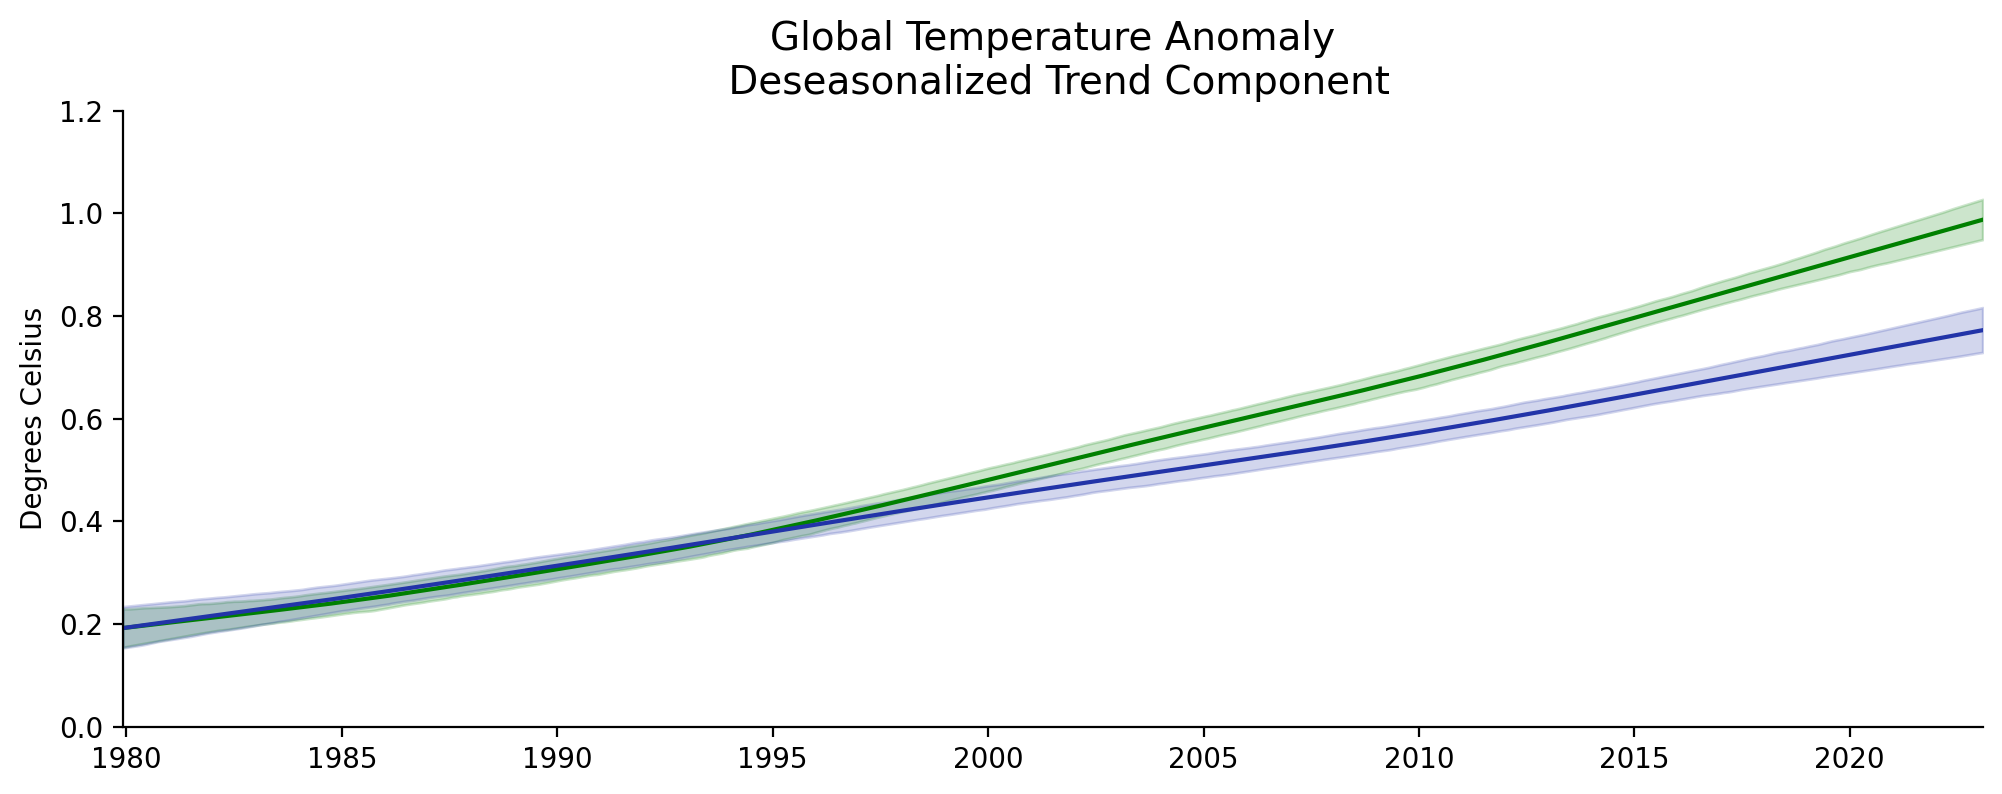

In [27]:
fig,ax = plt.subplots(figsize=(12,4), dpi=200)

ax.fill_between(surface_trend.index, surface_trend_lower, surface_trend_upper, color='green', alpha=0.2)
ax.plot(surface_trend.index, surface_trend, color='green')
ax.set_ylim(bottom=0, top=1.20)
ax.set_ylabel(ylabel='Degrees Celsius')
ax.set_xlim(left=surface_trend.index[0], right=surface_trend.index[-1])

ax.fill_between(satellite_trend_adj.index, satellite_trend_lower_adj, satellite_trend_upper_adj, color='#2234A8', alpha=0.2)
ax.plot(satellite_trend_adj.index, satellite_trend_adj, color='#2234A8')

ax.set_title("Global Temperature Anomaly\n Deseasonalized Trend Component", fontsize=14)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show();